In [90]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.colors import ListedColormap
register_matplotlib_converters()
from lightgbm import LGBMRegressor

In [3]:
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# https://www.kaggle.com/marketneutral/purged-rolling-time-series-cv-split
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [9]:
# Code from https://www.kaggle.com/gogo827jz/jane-street-ffill-xgboost-purgedtimeseriescv
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    
    cmap_cv = plt.cm.coolwarm

    jet = plt.cm.get_cmap('jet', 256)
    seq = np.linspace(0, 1, 256)
    _ = np.random.shuffle(seq)   # inplace
    cmap_data = ListedColormap(jet(seq))

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=plt.cm.Set3)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['target', 'day']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, len(y)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

# Data

In [5]:
os.chdir("..")
forecast_1 = pd.read_csv('data/wind_challenge/Dataset1_forecast.csv')
forecast_1['Time'] = pd.to_datetime(forecast_1['Time'])

In [203]:
forecast_1 = pd.read_csv('data/wind_challenge/Dataset3_forecast.csv')

In [253]:
df = pd.read_csv('processed/Datasets1_join.csv')
df['timeStamp'] = pd.to_datetime(df['timeStamp'])

In [254]:
df.head(20)

,timeStamp,availableMW,windSpeed,windPower,Time,windSpeed (m/s),windDic (degree)
0,2018-01-01 00:00:00,34.5,11.9,42.5118,2018-01-01 00:00:00,9.50241,303.854
1,2018-01-01 00:05:00,34.5,12.0,42.7067,NaN,NaN,NaN
2,2018-01-01 00:10:00,34.5,12.0,42.7067,NaN,NaN,NaN
3,2018-01-01 00:15:00,34.5,11.8,42.3044,NaN,NaN,NaN
4,2018-01-01 00:20:00,34.5,11.8,42.3044,NaN,NaN,NaN
5,2018-01-01 00:25:00,34.5,12.4,43.3869,NaN,NaN,NaN
6,2018-01-01 00:30:00,34.5,12.4,43.3869,NaN,NaN,NaN
7,2018-01-01 00:35:00,34.5,12.3,43.2298,NaN,NaN,NaN
8,2018-01-01 00:40:00,34.5,12.3,43.2298,NaN,NaN,NaN
9,2018-01-01 00:45:00,34.5,12.3,43.2298,NaN,NaN,NaN


In [255]:
df = df.interpolate()

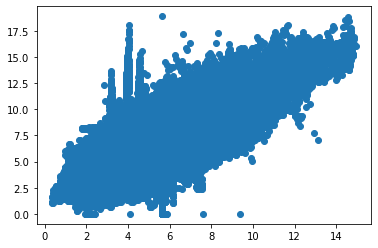

In [258]:
plt.scatter(df['windSpeed (m/s)'], df['windSpeed'])

In [259]:
train = df.copy()
train = train[['timeStamp', 'windSpeed (m/s)', 'windDic (degree)', 'windPower']]
#speed = speed.set_index('Time')
#speed = speed.asfreq('1h')

In [260]:
train.head(5)

,timeStamp,windSpeed (m/s),windDic (degree),windPower
0,2018-01-01 00:00:00,9.502410,303.854000,42.5118
1,2018-01-01 00:05:00,9.427808,303.623083,42.7067
2,2018-01-01 00:10:00,9.353207,303.392167,42.7067
3,2018-01-01 00:15:00,9.278605,303.161250,42.3044
4,2018-01-01 00:20:00,9.204003,302.930333,42.3044


# Wind speed model

### Features

In [261]:
train['y'] = train['windPower']

In [262]:
train['speed_lag_1'] = train['windSpeed (m/s)'].shift(1)
train['speed_lag_2'] = train['windSpeed (m/s)'].shift(2)
train['speed_lag_3'] = train['windSpeed (m/s)'].shift(3)
train['speed_lag_4'] = train['windSpeed (m/s)'].shift(4)
train['speed_lag_5'] = train['windSpeed (m/s)'].shift(5)
train['speed_lag_6'] = train['windSpeed (m/s)'].shift(6)

In [263]:
train['speed_rolling_6'] = train['windSpeed (m/s)'].rolling(6).mean()
train['speed_rolling_12'] = train['windSpeed (m/s)'].rolling(12).mean()

In [264]:
train

,timeStamp,windSpeed (m/s),windDic (degree),windPower,y,speed_lag_1,speed_lag_2,speed_lag_3,speed_lag_4,speed_lag_5,speed_lag_6,speed_rolling_6,speed_rolling_12
0,2018-01-01 00:00:00,9.502410,303.854000,42.5118,42.5118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01 00:05:00,9.427808,303.623083,42.7067,42.7067,9.502410,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01 00:10:00,9.353207,303.392167,42.7067,42.7067,9.427808,9.502410,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01 00:15:00,9.278605,303.161250,42.3044,42.3044,9.353207,9.427808,9.502410,NaN,NaN,NaN,NaN,NaN
4,2018-01-01 00:20:00,9.204003,302.930333,42.3044,42.3044,9.278605,9.353207,9.427808,9.502410,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88936,2018-12-30 23:40:00,3.272611,170.965032,0.0000,0.0000,3.222482,3.172352,3.122222,3.072093,3.021963,2.971834,3.147287,2.973198
88937,2018-12-30 23:45:00,3.322741,171.568802,0.0000,0.0000,3.272611,3.222482,3.172352,3.122222,3.072093,3.021963,3.197417,3.035178
88938,2018-12-30 23:50:00,3.372871,172.172572,0.0000,0.0000,3.322741,3.272611,3.222482,3.172352,3.122222,3.072093,3.247547,3.093208
88939,2018-12-30 23:55:00,3.423000,172.776341,0.0000,0.0000,3.372871,3.322741,3.272611,3.222482,3.172352,3.122222,3.297676,3.147287


### Variables

In [265]:
X_list = ['windDic (degree)', 'windSpeed (m/s)', 'speed_lag_1',
       'speed_lag_2', 'speed_lag_3', 'speed_lag_4', 'speed_lag_5',
       'speed_lag_6', 'speed_rolling_6', 'speed_rolling_12']
y_list = ['y']

### Train/Test

In [ ]:
valid = 

In [266]:
X = train[X_list].values
y = train[y_list].values.ravel()
dates = train["timeStamp"].values.ravel()

In [247]:
dates

array(['2018-01-01T00:00:00.000000000', '2018-01-01T00:05:00.000000000',
       '2018-01-01T00:10:00.000000000', ...,
       '2018-12-30T23:50:00.000000000', '2018-12-30T23:55:00.000000000',
       '2018-12-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [267]:
cv_dict = {
    "PurgedCV": PurgedGroupTimeSeriesSplit(n_splits=5, 
                                           group_gap=0, 
                                           max_train_group_size=15000, 
                                           max_test_group_size=5000)
}

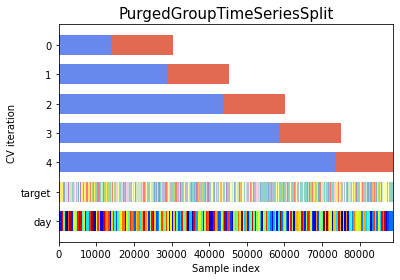

Wall time: 3min 18s


In [251]:
%%time

fig, ax = plt.subplots()
cv = cv_dict["PurgedCV"]
plot_cv_indices(cv, X, y, dates, ax, 5, lw = 20)
plt.show()

### Model

In [161]:
from sklearn.metrics import mean_squared_error
# Función para evaluar el modelo
def utility(estimator, X, y):
    """Custom scoring object as per documentation:
    https://scikit-learn.org/stable/modules/model_evaluation.html#implementing-your-own-scoring-object
    Utility score formulae are defined in competition's intro:
    https://www.kaggle.com/c/jane-street-market-prediction/overview/evaluation
    Using optimisation tricks from @gogo827jz:
    https://www.kaggle.com/c/jane-street-market-prediction/discussion/201257
    """

    # still looking for a way to write this for xgb.cv but it passes DMatrix which doesn't allow indexing...
    # https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html

    
    prediction = estimator.predict(X)
    #proba = estimator.predict_proba(X)[:, 1]
    mse = mean_squared_error(y, prediction)
    
    return mse


In [268]:
lgb_params = dict(#num_leaves=31, 
                       max_depth=7, 
                       learning_rate=0.01, 
                       n_estimators=200, 
                       objective="regression", 
                       min_child_weight=0.001, min_child_samples=20, 
                       subsample=1.0, subsample_freq=0, 
                       colsample_bytree=0.8, 
                       reg_alpha=1, reg_lambda=1, 
                       random_state=2, 
                       n_jobs=-1, 
                       silent=True, 
                       importance_type='split'
                      )

In [269]:
depths = [5, 7, 8, 9, 10, 11]

In [ ]:
score_cols = ["mse"]
score_df = pd.DataFrame([])

for cv_name, cv in cv_dict.items():
    print("*" * 10 + "  " + cv_name + "  " + "*" * 10)    
    for d in depths:
        print("*" * 5 + " Depth: ",d," "+ "*" * 5)
        new_lgb_params = lgb_params.copy()
        new_lgb_params["max_depth"] = d
        model = LGBMRegressor(**new_lgb_params)
        t_score = []
        v_score = []        
        for f,(t_idx, v_idx) in enumerate(cv.split(X, y, dates)):
            print("Fold "+str(f)+" :")
            X_t, X_v = X[t_idx], X[v_idx]
            y_t, y_v = y[t_idx], y[v_idx]
            model.fit(X_t, y_t, eval_set =[(X_v, y_v)], early_stopping_rounds = 20, verbose=True)
            iteration = model.best_iteration_
            print("Training Iteration: ", iteration)
            print("Train",end=":\t")
            t_mse = utility(model, X_t, y_t)
            print("Valid",end=":\t")
            v_mse = utility(model, X_v, y_v)
            t_score.append([t_mse,iteration])
            v_score.append([v_mse,iteration])  
        t_score_df = pd.DataFrame(t_score, columns = score_cols+["iteration"])
        v_score_df = pd.DataFrame(v_score, columns = score_cols+["iteration"])
        t_score_df["train"] = True 
        t_score_df["cv"] = cv_name
        t_score_df["depth"] = d
        v_score_df["train"] = False 
        v_score_df["cv"] = cv_name
        v_score_df["depth"] = d
        t_score_mean = t_score_df[score_cols].mean()
        t_score_std = t_score_df[score_cols].std()
        v_score_mean = v_score_df[score_cols].mean()
        v_score_std = v_score_df[score_cols].std()
        score_df = pd.concat([score_df, t_score_df, v_score_df],axis=0)

**********  PurgedCV  **********
***** Depth:  5  *****
Fold 0 :
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[1]	valid_0's l2: 209.516
Training until validation scores don't improve for 20 rounds
[2]	valid_0's l2: 207.425
[3]	valid_0's l2: 205.342
[4]	valid_0's l2: 203.307
[5]	valid_0's l2: 201.369
[6]	valid_0's l2: 199.441
[7]	valid_0's l2: 197.562
[8]	valid_0's l2: 195.765
[9]	valid_0's l2: 193.983
[10]	valid_0's l2: 192.234
[11]	valid_0's l2: 190.55
[12]	valid_0's l2: 188.889
[13]	valid_0's l2: 187.249
[14]	valid_0's l2: 185.715
[15]	valid_0's l2: 184.181
[16]	valid_0's l2: 182.675
[17]	valid_0's l2: 181.249
[18]	valid_0's l2: 179.841
[19]	valid_0's l2: 178.4
[20]	valid_0's l2: 177.085
[21]	valid_0's l2: 175.734
[22]	valid_0's l2: 174.518
[23]	valid_0's l2: 173.273
[24]	valid_0's l2: 172.102
[25]	valid_0's l2: 170.97
[26]	valid_0's l2: 169.831
[27]	valid_0's l2: 168.757
[28]	valid_0's l2: 167.617
[

[171]	valid_0's l2: 111.175
[172]	valid_0's l2: 111.052
[173]	valid_0's l2: 111.036
[174]	valid_0's l2: 110.984
[175]	valid_0's l2: 110.936
[176]	valid_0's l2: 110.889
[177]	valid_0's l2: 110.788
[178]	valid_0's l2: 110.825
[179]	valid_0's l2: 110.744
[180]	valid_0's l2: 110.719
[181]	valid_0's l2: 110.648
[182]	valid_0's l2: 110.617
[183]	valid_0's l2: 110.514
[184]	valid_0's l2: 110.488
[185]	valid_0's l2: 110.512
[186]	valid_0's l2: 110.456
[187]	valid_0's l2: 110.389
[188]	valid_0's l2: 110.38
[189]	valid_0's l2: 110.321
[190]	valid_0's l2: 110.267
[191]	valid_0's l2: 110.237
[192]	valid_0's l2: 110.24
[193]	valid_0's l2: 110.188
[194]	valid_0's l2: 110.111
[195]	valid_0's l2: 110.121
[196]	valid_0's l2: 110.126
[197]	valid_0's l2: 110.072
[198]	valid_0's l2: 110.072
[199]	valid_0's l2: 110.029
[200]	valid_0's l2: 109.974
Did not meet early stopping. Best iteration is:
[200]	valid_0's l2: 109.974
Training Iteration:  200
Train:	Valid:	Fold 2 :
[LightGBM] [Warning] Accuracy may be b

[75]	valid_0's l2: 92.5882
[76]	valid_0's l2: 92.0526
[77]	valid_0's l2: 91.4721
[78]	valid_0's l2: 90.9443
[79]	valid_0's l2: 90.4219
[80]	valid_0's l2: 89.9142
[81]	valid_0's l2: 89.4646
[82]	valid_0's l2: 88.976
[83]	valid_0's l2: 88.4994
[84]	valid_0's l2: 88.0173
[85]	valid_0's l2: 87.5609
[86]	valid_0's l2: 87.1235
[87]	valid_0's l2: 86.6915
[88]	valid_0's l2: 86.2396
[89]	valid_0's l2: 85.7769
[90]	valid_0's l2: 85.4063
[91]	valid_0's l2: 84.9977
[92]	valid_0's l2: 84.5858
[93]	valid_0's l2: 84.1924
[94]	valid_0's l2: 83.7917
[95]	valid_0's l2: 83.4248
[96]	valid_0's l2: 83.0641
[97]	valid_0's l2: 82.6946
[98]	valid_0's l2: 82.2948
[99]	valid_0's l2: 81.9032
[100]	valid_0's l2: 81.5208
[101]	valid_0's l2: 81.1816
[102]	valid_0's l2: 80.8688
[103]	valid_0's l2: 80.544
[104]	valid_0's l2: 80.1865
[105]	valid_0's l2: 79.8693
[106]	valid_0's l2: 79.5273
[107]	valid_0's l2: 79.1901
[108]	valid_0's l2: 78.8537
[109]	valid_0's l2: 78.5328
[110]	valid_0's l2: 78.2151
[111]	valid_0's l2:

[169]	valid_0's l2: 57.3879
[170]	valid_0's l2: 57.3303
[171]	valid_0's l2: 57.2939
[172]	valid_0's l2: 57.2731
[173]	valid_0's l2: 57.2118
[174]	valid_0's l2: 57.1734
[175]	valid_0's l2: 57.1295
[176]	valid_0's l2: 57.0738
[177]	valid_0's l2: 57.04
[178]	valid_0's l2: 57.012
[179]	valid_0's l2: 56.9985
[180]	valid_0's l2: 56.9923
[181]	valid_0's l2: 56.9818
[182]	valid_0's l2: 56.9603
[183]	valid_0's l2: 56.9611
[184]	valid_0's l2: 56.9175
[185]	valid_0's l2: 56.9128
[186]	valid_0's l2: 56.8818
[187]	valid_0's l2: 56.8895
[188]	valid_0's l2: 56.879
[189]	valid_0's l2: 56.8651
[190]	valid_0's l2: 56.8509
[191]	valid_0's l2: 56.818
[192]	valid_0's l2: 56.8124
[193]	valid_0's l2: 56.8255
[194]	valid_0's l2: 56.8026
[195]	valid_0's l2: 56.7938
[196]	valid_0's l2: 56.8004
[197]	valid_0's l2: 56.7999
[198]	valid_0's l2: 56.7903
[199]	valid_0's l2: 56.8063
[200]	valid_0's l2: 56.8154
Did not meet early stopping. Best iteration is:
[198]	valid_0's l2: 56.7903
Training Iteration:  198
Train:	V

[148]	valid_0's l2: 109.605
[149]	valid_0's l2: 109.511
[150]	valid_0's l2: 109.372
[151]	valid_0's l2: 109.283
[152]	valid_0's l2: 109.237
[153]	valid_0's l2: 109.142
[154]	valid_0's l2: 109.012
[155]	valid_0's l2: 108.937
[156]	valid_0's l2: 108.856
[157]	valid_0's l2: 108.801
[158]	valid_0's l2: 108.693
[159]	valid_0's l2: 108.651
[160]	valid_0's l2: 108.569
[161]	valid_0's l2: 108.463
[162]	valid_0's l2: 108.384
[163]	valid_0's l2: 108.297
[164]	valid_0's l2: 108.207
[165]	valid_0's l2: 108.138
[166]	valid_0's l2: 108.078
[167]	valid_0's l2: 108.046
[168]	valid_0's l2: 107.968
[169]	valid_0's l2: 107.897
[170]	valid_0's l2: 107.865
[171]	valid_0's l2: 107.84
[172]	valid_0's l2: 107.772
[173]	valid_0's l2: 107.742
[174]	valid_0's l2: 107.647
[175]	valid_0's l2: 107.603
[176]	valid_0's l2: 107.587
[177]	valid_0's l2: 107.553
[178]	valid_0's l2: 107.493
[179]	valid_0's l2: 107.443
[180]	valid_0's l2: 107.427
[181]	valid_0's l2: 107.366
[182]	valid_0's l2: 107.356
[183]	valid_0's l2: 1

[31]	valid_0's l2: 130.535
[32]	valid_0's l2: 129.226
[33]	valid_0's l2: 127.992
[34]	valid_0's l2: 126.745
[35]	valid_0's l2: 125.51
[36]	valid_0's l2: 124.298
[37]	valid_0's l2: 123.056
[38]	valid_0's l2: 121.943
[39]	valid_0's l2: 120.793
[40]	valid_0's l2: 119.751
[41]	valid_0's l2: 118.635
[42]	valid_0's l2: 117.609
[43]	valid_0's l2: 116.496
[44]	valid_0's l2: 115.49
[45]	valid_0's l2: 114.517
[46]	valid_0's l2: 113.588
[47]	valid_0's l2: 112.64
[48]	valid_0's l2: 111.629
[49]	valid_0's l2: 110.693
[50]	valid_0's l2: 109.817
[51]	valid_0's l2: 108.883
[52]	valid_0's l2: 108.004
[53]	valid_0's l2: 107.088
[54]	valid_0's l2: 106.217
[55]	valid_0's l2: 105.409
[56]	valid_0's l2: 104.54
[57]	valid_0's l2: 103.786
[58]	valid_0's l2: 102.972
[59]	valid_0's l2: 102.179
[60]	valid_0's l2: 101.398
[61]	valid_0's l2: 100.64
[62]	valid_0's l2: 99.9251
[63]	valid_0's l2: 99.1783
[64]	valid_0's l2: 98.4542
[65]	valid_0's l2: 97.7561
[66]	valid_0's l2: 97.0411
[67]	valid_0's l2: 96.3881
[68]	v

[139]	valid_0's l2: 61.4233
[140]	valid_0's l2: 61.3184
[141]	valid_0's l2: 61.1902
[142]	valid_0's l2: 61.0436
[143]	valid_0's l2: 60.9009
[144]	valid_0's l2: 60.8022
[145]	valid_0's l2: 60.6653
[146]	valid_0's l2: 60.5294
[147]	valid_0's l2: 60.4305
[148]	valid_0's l2: 60.3321
[149]	valid_0's l2: 60.2377
[150]	valid_0's l2: 60.1539
[151]	valid_0's l2: 60.077
[152]	valid_0's l2: 59.9603
[153]	valid_0's l2: 59.8849
[154]	valid_0's l2: 59.813
[155]	valid_0's l2: 59.736
[156]	valid_0's l2: 59.6674
[157]	valid_0's l2: 59.6065
[158]	valid_0's l2: 59.5434
[159]	valid_0's l2: 59.4455
[160]	valid_0's l2: 59.4081
[161]	valid_0's l2: 59.3474
[162]	valid_0's l2: 59.2933
[163]	valid_0's l2: 59.2465
[164]	valid_0's l2: 59.1885
[165]	valid_0's l2: 59.1383
[166]	valid_0's l2: 59.0953
[167]	valid_0's l2: 59.0154
[168]	valid_0's l2: 58.9915
[169]	valid_0's l2: 58.9518
[170]	valid_0's l2: 58.9148
[171]	valid_0's l2: 58.8778
[172]	valid_0's l2: 58.8344
[173]	valid_0's l2: 58.7692
[174]	valid_0's l2: 58.

[110]	valid_0's l2: 113.842
[111]	valid_0's l2: 113.637
[112]	valid_0's l2: 113.495
[113]	valid_0's l2: 113.354
[114]	valid_0's l2: 113.176
[115]	valid_0's l2: 113.032
[116]	valid_0's l2: 112.842
[117]	valid_0's l2: 112.722
[118]	valid_0's l2: 112.549
[119]	valid_0's l2: 112.396
[120]	valid_0's l2: 112.251
[121]	valid_0's l2: 112.109
[122]	valid_0's l2: 111.987
[123]	valid_0's l2: 111.838
[124]	valid_0's l2: 111.703
[125]	valid_0's l2: 111.573
[126]	valid_0's l2: 111.436
[127]	valid_0's l2: 111.356
[128]	valid_0's l2: 111.198
[129]	valid_0's l2: 111.091
[130]	valid_0's l2: 111.001
[131]	valid_0's l2: 110.886
[132]	valid_0's l2: 110.774
[133]	valid_0's l2: 110.649
[134]	valid_0's l2: 110.515
[135]	valid_0's l2: 110.389
[136]	valid_0's l2: 110.293
[137]	valid_0's l2: 110.164
[138]	valid_0's l2: 110.119
[139]	valid_0's l2: 109.99
[140]	valid_0's l2: 109.885
[141]	valid_0's l2: 109.787
[142]	valid_0's l2: 109.718
[143]	valid_0's l2: 109.653
[144]	valid_0's l2: 109.615
[145]	valid_0's l2: 1

[196]	valid_0's l2: 69.7523
[197]	valid_0's l2: 69.6835
[198]	valid_0's l2: 69.6027
[199]	valid_0's l2: 69.5265
[200]	valid_0's l2: 69.4469
Did not meet early stopping. Best iteration is:
[200]	valid_0's l2: 69.4469
Training Iteration:  200
Train:	Valid:	Fold 3 :
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[1]	valid_0's l2: 183.972
Training until validation scores don't improve for 20 rounds
[2]	valid_0's l2: 181.645
[3]	valid_0's l2: 179.301
[4]	valid_0's l2: 177.009
[5]	valid_0's l2: 174.792
[6]	valid_0's l2: 172.589
[7]	valid_0's l2: 170.461
[8]	valid_0's l2: 168.373
[9]	valid_0's l2: 166.289
[10]	valid_0's l2: 164.251
[11]	valid_0's l2: 162.276
[12]	valid_0's l2: 160.328
[13]	valid_0's l2: 158.443
[14]	valid_0's l2: 156.588
[15]	valid_0's l2: 154.698
[16]	valid_0's l2: 152.889
[17]	valid_0's l2: 151.151
[18]	valid_0's l2: 149.414
[19]	valid_0's l2: 147.696
[20]	valid_0's l2: 146.066
[21]	valid_0's

### Validation

In [ ]:
score_df